# 3. Linear Models for Regression

### *Table of Contents*

* 3.1 [Linear Basis Function Models](#3.1-Linear-Basis-Function-Models)
    * 3.1.1 [Maximum likelihood and least squares](#3.1.1-Maximum-likelihood-and-least-squares)
    * 3.1.3 [Sequential learning](#3.1.3-Sequential-learning)
    * 3.1.4 [Regularized least squares](#3.1.4-Regularized-least-squares)
* 3.2 [The Bias-Variance Decomposition](#3.2-Bias-Variance-Decomposition)
* 3.3 [Bayesian Linear Regression](#3.3-Bayesian-Linear-Regression)
    * 3.3.1 [Parameter distribution](#3.3.1-Parameter-distribution)
    * 3.3.2 [Predictive distribution](#3.3.2-Predictive-distribution)
    * 3.3.3 [Equivalent kernel](#3.3.3-Equivalent-kernel)
* 3.5 [The Evidence Approximation](#3.5-The-Evidence-Approximation)
    * 3.5.1 [Evaluation of the evidence function](#3.5.1-Evaluation-of-the-evidence-function)
    * 3.5.2 [Maximizing the evidence function](#3.5.2-Maximizing-the-evidence-function)

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from prml.datasets import generate_toy_data
from prml.distribution import (
    Gaussian,
    MultivariateGaussian
)
from prml.preprocessing import (
    PolynomialFeature,
    GaussianFeature,
    SigmoidFeature
)
from prml.linear import (
    LinearRegression,
    RidgeRegression,
    BayesianRegression,
    EvidenceApproximation
)

# Set random seed to make deterministic
np.random.seed(0)

# Ignore zero divisions and computation involving NaN values.
# np.seterr(divide = 'ignore', invalid='ignore')

The goal of regression is to predict the value of one or more **continuous** target variables $t$ given the value of a $D$-dimensional vector $\mathbf{x}$ of input variables. The polynomial curve that we used in [Chapter 1](ch1_introduction.ipynb) belongs to a broader class of functions called linear regression models, that are linear functions of the adjustable parameters. The simplest form of linear regression models are also linear functions of the input variables $\mathbf{x}$. However, a much more useful class of functions is the linear combinations of a fixed set of nonlinear functions of the input variables, known as *basis functions*.

## 3.1 Linear Basis Function Models

The simplest linear model for regression is one that involves a linear combination of the input variables

$$
y(\mathbf{x}, \mathbf{w}) = w_0 + w_1x_1 + \dots + w_Dx_D
$$

which is simply known as *linear regression*. This model is a linear function of the parameters and a linear function of the input variables, and this imposes significant limitations on the model. We therefore extend the class of models by considering linear combinations of fixed nonlinear functions of the input variables, of the form

$$
y(\mathbf{x}, \mathbf{w}) = w_0 + \sum_{j=1}^{M-1} w_j\phi_j(\mathbf{x}) = 
\sum_{j=0}^{M-1} w_j\phi_j(\mathbf{x}) = \mathbf{w}^T\boldsymbol\phi(\mathbf{x})
$$

where $\phi_j(\mathbf{x})$ are known as *basis functions*.

The polynomial regression considered in [Chapter 1](ch1_introduction.ipynb) is an example of this model in which there is a single input variable $x$, and the basis functions take the form of powers of $x$ so that $\phi_j(x)=x^j$. There is a plethora of possible choices for the basis functions, for instance

$$
\phi_j(x) = \exp\bigg\{ -\frac{(x - \mu_j)^2}{2s^2} \bigg\}
$$

are referred to as *Gaussian* basis functions, where $\mu_j$ govern the locations of the functions in input space, and $s$ governs their spatial scale. Another possibility is the sigmoidal basis function of the form

$$
\phi_j(x) = \sigma\bigg( \frac{x - \mu_j}{s} \bigg)
$$

where $\sigma(a)$ is the logistic sigmoid function defined by

$$
\sigma(a) = \frac{1}{1 + \exp(-a)}
$$

We present examples of these three families of basis functions using different parameters.

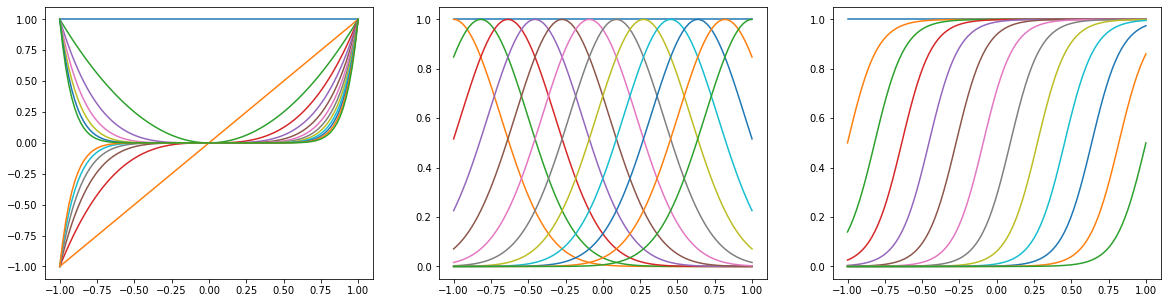

In [2]:
x_space = np.linspace(-1, 1, 100)

# Create 10 degree polynomial basis functions
x_polynomial = PolynomialFeature(degree=12).transform(x_space)

# Create 10 Gaussian basis functions
x_gaussian = GaussianFeature(mean=np.linspace(-1, 1, 12), sigma=0.1).transform(x_space)

# Create 10 sigmoid basis functions
x_sigmoid = SigmoidFeature(mean=np.linspace(-1, 1, 12), sigma=0.1).transform(x_space)

plt.figure(figsize=(20, 5))
for i, x in enumerate([x_polynomial, x_gaussian, x_sigmoid]):
    plt.subplot(1, 3, i + 1)
    for j in range(x.shape[1]):
        plt.plot(x_space, x[:, j])

### 3.1.1 Maximum likelihood and least squares

In [Chapter 1](ch1_introduction.ipynb), we fitted polynomial functions to data sets by minimizing a sum-of-squares error function. We also showed that this error function could be motivated as the maximum likelihood solution under an assumed Gaussian noise model. Let us return to the discussion of [Chapter 1](ch1_introduction.ipynb) and consider the least squares approach, and its relation to maximum likelihood, in more detail.

As before, we assume that the target variable $t$ is given by a deterministic function $y(\mathbf{x},\mathbf{w})$ having additive Gaussian noise so that

$$
t = y(\mathbf{x},\mathbf{w}) + \epsilon
$$

where $\epsilon$ is a zero mean Gaussian random variable with precision (inverse variance) $\beta$. Thus we can write

$$
p(t|\mathbf{x},\mathbf{w},\beta) = \mathcal{N}(t|y(\mathbf{x},\mathbf{w}),\beta^{-1})
$$

Note that the Gaussian noise assumption implies that the conditional distribution of $t$ given $\mathbf{x}$ is unimodal, which may be inappropriate for some applications.

Now consider a data set of inputs $\mathbf{X}=\{\mathbf{x}_1,\dots,\mathbf{x}_N\}$ along corresponding target alues $\mathsf{t}=(t_1,\dots,t_N)^{\text{T}}$. Assuming that the data points are i.i.d, we obtain the likelihood function (function of the adjustable parameters $\mathbf{w}$ and $\beta$), in the form

$$
p(\mathsf{t}|\mathbf{X},\mathbf{w},\beta) = 
\prod_{n=1}^N \mathcal{N}(t_n|y(\mathbf{x}_n,\mathbf{w}),\beta^{-1}) = 
\prod_{n=1}^N \mathcal{N}(t_n|\mathbf{w}^{\text{T}}\boldsymbol\phi(\mathbf{x}_n),\beta^{-1})
$$

**NOTE**: In many textbooks, the input variables $\mathbf{x}$ are dropped from the set of conditioning variables, since, we do not seek to model the distribution of $\mathbf{x}$.

Taking the logarithm of the likelihood function, we have,

$$
\begin{align*}
\ln p(\mathsf{t}|\mathbf{X},\mathbf{w},\beta) &= 
\sum_{n=1}^N \ln\mathcal{N}(t_n|\mathbf{w}^{\text{T}}\boldsymbol\phi(\mathbf{x}_n),\beta^{-1}) \\
&= \frac{N}{2}\ln\beta - \frac{N}{2}\ln 2\pi - 
\frac{\beta}{2}\sum_{n=1}^N \big(t_n - \mathbf{w}^{\text{T}}\boldsymbol\phi(\mathbf{x}_n)\big)^2 \\
&= \frac{N}{2}\ln\beta - \frac{N}{2}\ln 2\pi - \beta E_D(\mathbf{w})
\end{align*}
$$

By maximizing likelihood we can determine the parameters $\mathbf{w}$ and $\beta$. As already observed in [Chapter 1](ch1_introduction.ipynb) the maximization under a conditional Gaussian noise distribution is equivalent to minimizing the sum-of-squares error function given by $E_D(\mathbf{w})$. The gradient of the log likelihood function takes the form

$$
\nabla p(\mathsf{t}|\mathbf{X},\mathbf{w},\beta) = 
\sum_{n=1}^N \big(t_n - \mathbf{w}^{\text{T}}\boldsymbol\phi(\mathbf{x}_n)\big)\boldsymbol\phi(\mathbf{x}_n)^{\text{T}}
$$

Setting this gradient to zero and solving for $\mathbf{w}$ gives

$$
\mathbf{w}_{ML} = (\mathbf{\Phi}^{\text{T}}\mathbf{\Phi})^{-1}\mathbf{\Phi}^{\text{T}}\mathsf{t}
$$

which are known as the *normal equations* for the least squares problem. Here $\mathbf{\Phi}$ is an $N\times M$ matrix, called the *design matrix*, whose elements are given by $\Phi_{nj} = \phi_j(\mathbf{x}_n)$, so that

$$
\mathbf{\Phi}= 
\begin{pmatrix}
\phi_0(\mathbf{x}_1) & \phi_1(\mathbf{x}_1) & \cdots & \phi_{M-1}(\mathbf{x}_1) \\
\phi_0(\mathbf{x}_2) & \phi_1(\mathbf{x}_2) & \cdots & \phi_{M-1}(\mathbf{x}_2) \\
\vdots  & \vdots  & \ddots & \vdots  \\
\phi_0(\mathbf{x}_N) & \phi_1(\mathbf{x}_N) & \cdots & \phi_{M-1}(\mathbf{x}_N)
\end{pmatrix}
$$

By maximizing the log likelihood function over the noise precision parameter $\beta$, we obtain

$$
\beta_{ML} = \frac{1}{N}\sum_{n=1}^N (t_n - \mathbf{w}^{\text{T}}\boldsymbol\phi(\mathbf{x}_n))^2
$$

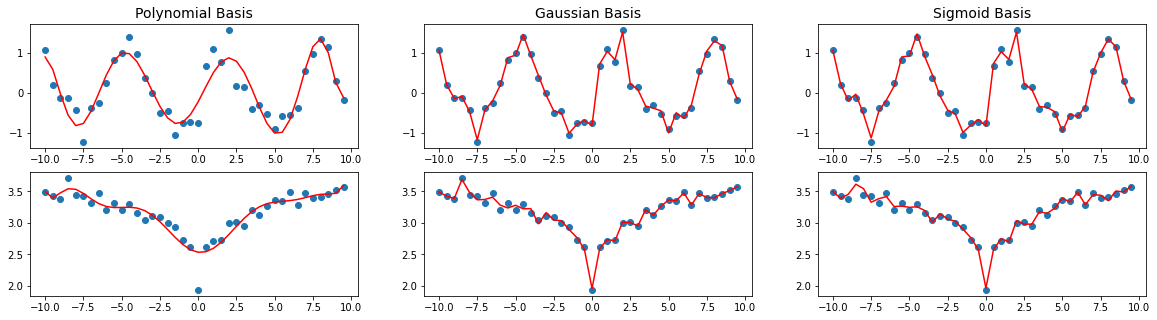

In [3]:
# Create polynomial, gaussian and sigmoid basis functions
polynomial_basis = PolynomialFeature(degree=10)
gaussian_basis = GaussianFeature(mean=np.arange(-9, 9, 0.5), sigma=1)
sigmoid_basis = SigmoidFeature(mean=np.arange(-9, 9, 0.5), sigma=1)

# Lets train a linear regression model on a couple of datasets 
model = LinearRegression()

plt.figure(figsize=(20, 5))

X = np.arange(-10, 10, 0.5).reshape((-1, 1))
y = np.sin(X) + np.random.randn(X.shape[0], X.shape[1]) * 0.3

for i, basis in enumerate([polynomial_basis, gaussian_basis, sigmoid_basis]):
    plt.subplot(2, 3, i + 1)
    plt.scatter(X, y)
    x_train_features = basis.transform(X)    
    model.fit(x_train_features, y)
    plt.plot(X, model.predict(x_train_features), color='red')
    plt.title(['Polynomial Basis', 'Gaussian Basis', 'Sigmoid Basis'][i], fontsize=14)

X = np.arange(-10, 10, 0.5)
y = 0.8 * abs(X)**0.3 + 2 + np.random.randn(X.shape[0]) * 0.1

for i, basis in enumerate([polynomial_basis, gaussian_basis, sigmoid_basis]):
    plt.subplot(2, 3, i + 4)
    plt.scatter(X, y)
    x_train_features = basis.transform(X)    
    model.fit(x_train_features, y)
    plt.plot(X, model.predict(x_train_features), color='red')

plt.show()

### 3.1.3 Sequential learning

Batch learning, such as the maximum likelihood solution, requires processing of the entire training set at once. However, this can be computationally costly for large datasets. Sequential learning or *online* learning algorithms consider data points one at a time and update the model parameters after processing each point. We can obtain a sequential learning algorithm by applying a technique called *stochastic gradient descent* also known as *sequential gradient descent*. 

If an error function comprises a sum over data points, then for a data point $n$, the stochastic gradient descent updates the parameter vector $\mathbf{w}$ as follows,

$$
\mathbf{w}^{(\tau+1)} = \mathbf{w}^{(\tau)} - \eta\nabla E_n
$$

where $\tau$ is the iteration number and $\eta$ is a learning rate parameter. The value of $\mathbf{w}^{(0)}$ can be initialized to some random vector. For the case of the sum-of-squares error function, this gives

$$
\mathbf{w}^{(\tau+1)} = \mathbf{w}^{(\tau)} - \eta(\mathbf{w}^{(\tau)T}\boldsymbol\phi_n - t_n)\boldsymbol\phi_n
$$

This is also known as the *least-mean-squares* (LMS) algorithm or more commonly as gradient descent.

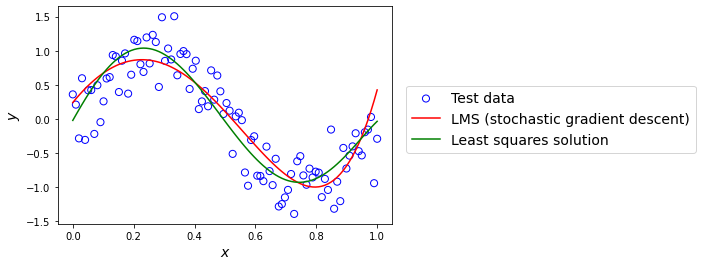

In [24]:
# Generate an example dateset
sin = lambda x: np.sin(2 * np.pi * x)
x_train, y_train = generate_toy_data(sin, sample_size=100, std=0.3)
x_test, y_test = generate_toy_data(sin, sample_size=100, std=0.3)

# Create polynomial features
polynomial = PolynomialFeature(degree=5)
x_train_features = polynomial.transform(x_train)
x_test_features = polynomial.transform(x_test)

# Fit linear regression using both gradient descent and least squares
model = LinearRegression()
model.fit_lms(x_train_features, y_train, eta=0.1)
y_pred_lms = model.predict(x_test_features)

model.fit(x_train_features, y_train)
y_pred_ls = model.predict(x_test_features)

plt.scatter(x_test, y_test, facecolor="none", edgecolor="b", s=50, label="Test data")
plt.plot(x_test, y_pred_lms, color="r", label="LMS (stochastic gradient descent)")
plt.plot(x_test, y_pred_ls, color="g", label="Least squares solution")
plt.xlabel('$x$', fontsize=14); plt.ylabel('$y$', fontsize=14)
plt.legend(bbox_to_anchor=(1, 0.7), loc=2, borderaxespad=1, fontsize=14); 
plt.show()

### 3.1.4 Regularized least squares

In [Chapter 1](ch1_introduction.ipynb), we introduced the idea of adding a regularization term to the error function in order to control over-fitting. To that end, the total error function to be minimized takes the form,

$$
E_D(\mathbf{w}) + \lambda E_W(\mathbf{w})
$$

where $\lambda$ is the regularization coefficient that controls the balance between the *data-dependent error* $E_D(\mathbf{w})$ and the regularization term over the parameters $E_W(\mathbf{w})$. One of the simplest regularizers we can employ is given by the sum-of-squares of the weight vector

$$
E_W(\mathbf{w}) = \frac{1}{2}\mathbf{w}^T\mathbf{w}
$$

Combining the sum-of-squares error function for the data and the quadratic regularizer leads to the following total error function

$$
\frac{1}{2}\sum_{n=1}^N \{t_n - \mathbf{w}^T\boldsymbol\phi(\mathbf{x}_n)\}^2 + \frac{\lambda}{2}\mathbf{w}^T\mathbf{w}
$$

This particular regularizer is also known as *weight decay* since it encourages weight values to decay towards zero, unless supported by data. In statistics, it provides an example of a *parameter shrinkage* method. Moreover, it has the advantage that the error function remains quadratic over $\mathbf{w}$, thus, it can be minimized in closed form using calculus.

A more general formulation for the regularized error is given by

$$
E_W(\mathbf{w}) = \frac{\lambda}{2}\sum_{j=1}^M|w_j|^q
$$

where $q=2$ recovers the quadratic regularizer. The case of $q=1$ is known as the *lasso* in the literature. It has the property that if $\lambda$ is sufficiently large, some of the parameters $w_j$ are driven to zero, leading to sparse models in which the corresponding basis function plays no role.

Regularization allows complex models (having a large number of parameters) to be trained on data sets of limited size, avoiding over-fitting. Unfortunately, the problem of determining the optimal model is then shifted from finding the appropriate number of basis functions to determining a suitable value for the regularization coefficient $\lambda$.

## 3.2 Bias-Variance Decomposition

The introduction of regularization terms can control over-fitting for models having many parameters. However, the question of how to determine a suitable value for the regularization coefficient $\lambda$ remains. Seeking the solution that minimizes the regularized error function with respect to both the weight vector and the regularization coefficient $\lambda$ is not the right approach since it leads to the unregularized solution $\lambda=0$.

The optimal prediction for the squared loss function is given by the conditional expectation

$$
h(\mathbf{x}) = \mathbb{E}[t|\mathbf{x}] = \int tp(t|\mathbf{x})\text{d}t
$$

Moreover, the expected squared loss is given by

$$
\mathbb{E}[L] = \int \big\{y(\mathbf{x}) - h(\mathbf{x})\big\}^2 p(\mathbf{x})\text{d}\mathbf{x} + 
\int\int \big\{h(\mathbf{x}) - t\big\}^2 p(\mathbf{x},t)\text{d}\mathbf{x}\text{d}t
$$

The second term is independent of $y(\mathbf{x})$ and arises from the intrinsic noise on the data. Assuming we can find a function $y(\mathbf{x}) = h(\mathbf{x})$, the second term represents the minimum achievable value of the expected loss. Thus, our goal is indeed to find a function $y(\mathbf{x})$ that makes the first term a minimum, ideally zero, since the loss function is always non-negative.

A frequentist treatment of the problem involves making an estimate of $\mathbf{w}$ based on a data set $\mathcal{D}$. In order to interpret the uncertainty of this estimate consider the following thought experiment. Suppose we had a large number of data sets each of size $N$, drawn independently from $p(t,\mathbf{x})$. Then, considering each dataset in turn, we can obtain a prediction function $y(\mathbf{x};\mathcal{D})$. As expected, each dataset should give a different functions and consequently different values for the squared loss. The performance of a particular learning algorithm can then be assesed by taking the average over this ensemble of data sets.

Now consider the integrand of the first them, given a particular dataset,

$$
\big\{y(\mathbf{x};\mathcal{D}) - h(\mathbf{x})\big\}^2
$$

If we add and subtract the average of $y(\mathbf{x};\mathcal{D})$ over the ensemble of data sets, expressed as $\mathbb{E}_{\mathcal{D}}[y(\mathbf{x};\mathcal{D})]$, we obtain

$$
\begin{align*}
& \big\{y(\mathbf{x};\mathcal{D}) - \mathbb{E}_{\mathcal{D}}[y(\mathbf{x};\mathcal{D})] +
\mathbb{E}_{\mathcal{D}}[y(\mathbf{x};\mathcal{D})] - h(\mathbf{x})\big\}^2 \\
& = \big\{y(\mathbf{x};\mathcal{D}) - \mathbb{E}_{\mathcal{D}}[y(\mathbf{x};\mathcal{D})]\big\}^2
+ \big\{\mathbb{E}_{\mathcal{D}}[y(\mathbf{x};\mathcal{D})] - h(\mathbf{x})\big\}^2
- 2\big\{y(\mathbf{x};\mathcal{D}) - \mathbb{E}_{\mathcal{D}}[y(\mathbf{x};\mathcal{D})]\big\}\big\{\mathbb{E}_{\mathcal{D}}[y(\mathbf{x};\mathcal{D})] - h(\mathbf{x})\big\}
\end{align*}
$$

By taking the expectation over all data sets $\mathcal{D}$ on both sides of the equation, we obtain

$$
\begin{align*}
& \mathbb{E}_{\mathcal{D}}\Big[\big\{y(\mathbf{x};\mathcal{D}) - h(\mathbf{x})\big\}^2\Big] \\
& = \mathbb{E}_{\mathcal{D}}\Big[
\big\{y(\mathbf{x};\mathcal{D}) - \mathbb{E}_{\mathcal{D}}[y(\mathbf{x};\mathcal{D})]\big\}^2
+ \big\{\mathbb{E}_{\mathcal{D}}[y(\mathbf{x};\mathcal{D})] - h(\mathbf{x})\big\}^2
- 2\big\{y(\mathbf{x};\mathcal{D}) - \mathbb{E}_{\mathcal{D}}[y(\mathbf{x};\mathcal{D})]\big\}\big\{\mathbb{E}_{\mathcal{D}}[y(\mathbf{x};\mathcal{D})] - h(\mathbf{x})\big\}
\Big] \\
&= \mathbb{E}_{\mathcal{D}}\Big[
\big\{y(\mathbf{x};\mathcal{D}) - \mathbb{E}_{\mathcal{D}}[y(\mathbf{x};\mathcal{D})]\big\}^2
\Big]
+ \mathbb{E}_{\mathcal{D}}\Big[
\big\{\mathbb{E}_{\mathcal{D}}[y(\mathbf{x};\mathcal{D})] - h(\mathbf{x})\big\}^2
\Big]
- \mathbb{E}_{\mathcal{D}}\Big[
2\big\{y(\mathbf{x};\mathcal{D}) - \mathbb{E}_{\mathcal{D}}[y(\mathbf{x};\mathcal{D})]\big\}\big\{\mathbb{E}_{\mathcal{D}}[y(\mathbf{x};\mathcal{D})] - h(\mathbf{x})\big\}
\Big] \\
&= \mathbb{E}_{\mathcal{D}}\Big[
\big\{y(\mathbf{x};\mathcal{D}) - \mathbb{E}_{\mathcal{D}}[y(\mathbf{x};\mathcal{D})]\big\}^2
\Big]
+ \mathbb{E}_{\mathcal{D}}\Big[
\big\{\mathbb{E}_{\mathcal{D}}[y(\mathbf{x};\mathcal{D})] - h(\mathbf{x})\big\}^2
\Big] \\
&- \mathbb{E}_{\mathcal{D}}\Big[
2\big\{
y(\mathbf{x};\mathcal{D})\mathbb{E}_{\mathcal{D}}[y(\mathbf{x};\mathcal{D})]
- y(\mathbf{x};\mathcal{D})h(\mathbf{x}) 
- \mathbb{E}_{\mathcal{D}}[y(\mathbf{x};\mathcal{D})]^2
+ \mathbb{E}_{\mathcal{D}}[y(\mathbf{x};\mathcal{D})]h(\mathbf{x})\big\}
\Big] \\
&= \mathbb{E}_{\mathcal{D}}\Big[
\big\{y(\mathbf{x};\mathcal{D}) - \mathbb{E}_{\mathcal{D}}[y(\mathbf{x};\mathcal{D})]\big\}^2
\Big]
+ \mathbb{E}_{\mathcal{D}}\Big[
\big\{\mathbb{E}_{\mathcal{D}}[y(\mathbf{x};\mathcal{D})] - h(\mathbf{x})\big\}^2
\Big] \\
&- 2\mathbb{E}_{\mathcal{D}}[y(\mathbf{x};\mathcal{D})]^2
+ 2\mathbb{E}_{\mathcal{D}}[y(\mathbf{x};\mathcal{D})]h(\mathbf{x})
+ 2\mathbb{E}_{\mathcal{D}}[y(\mathbf{x};\mathcal{D})]^2
- 2\mathbb{E}_{\mathcal{D}}[y(\mathbf{x};\mathcal{D})]h(\mathbf{x}) \\
&= \mathbb{E}_{\mathcal{D}}\Big[
\big\{\mathbb{E}_{\mathcal{D}}[y(\mathbf{x};\mathcal{D})] - h(\mathbf{x})\big\}^2
\Big]
+ \mathbb{E}_{\mathcal{D}}\Big[
\big\{y(\mathbf{x};\mathcal{D}) - \mathbb{E}_{\mathcal{D}}[y(\mathbf{x};\mathcal{D})]\big\}^2
\Big] \\
&= \big\{\mathbb{E}_{\mathcal{D}}[y(\mathbf{x};\mathcal{D})] - h(\mathbf{x})\big\}^2
+ \mathbb{E}_{\mathcal{D}}\Big[
\big\{y(\mathbf{x};\mathcal{D}) - \mathbb{E}_{\mathcal{D}}[y(\mathbf{x};\mathcal{D})]\big\}^2
\Big]
\end{align*}
$$

Note that the last term vanished giving a sum of two terms for the expected squarred loss. The first term, called the **squared bias**, represents the extend to which the average prediction over all data sets differs from the optimal loss function $h(\mathbf{x})$. The second term, called **variance**, measures the extend to which the solutions for each data set vary around their average, in other words, it measures how sensitive is function $y(\mathbf{x};\mathcal{D})$ to the particular choice of data set.

By substituting this decomposision of the squared loss back into the expected squared loss, we note that

$$
\text{expected loss} = (\text{bias})^2 + \text{variance} + \text{noise}
$$

Our goal is to minimize the expected loss, thus, minimizing both the bias and the variance. However, there is a trade-off between bias and variance. Very flexible models have low bias and high variance, while relatively rigid models have high bias and low variance. The best model is the one that balances these two quantities.

Consider $L=100$ data sets, each containing $N=25$ data points, independently from the sinusoidal curve $h(x)=\sin(2\pi x)$. For each data set $\mathcal{D}^{(l)}$, a model using $24$ Gaussian basis functions is trained, by minimizing the regularized error function to give a prediction function $y^{(l)}$. 

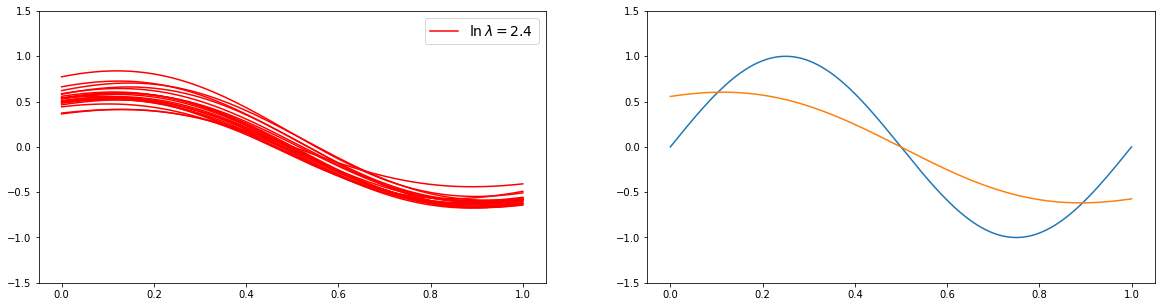

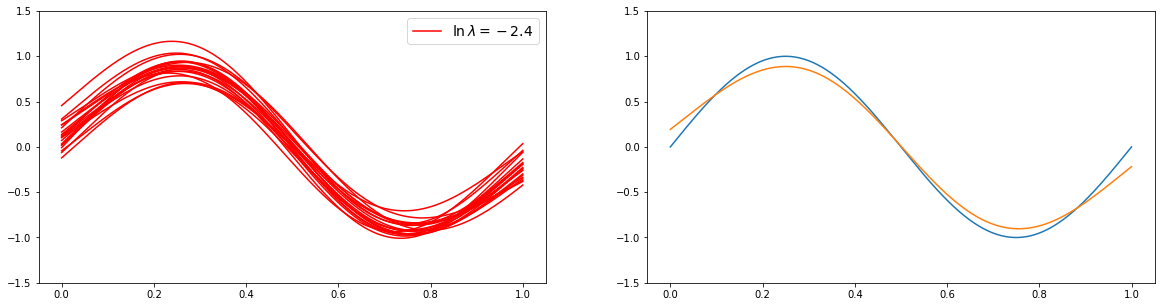

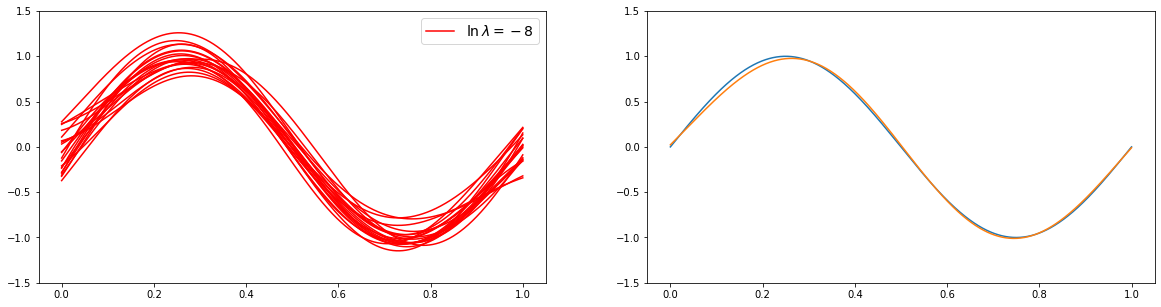

In [11]:
L = 100 # number of datasets
N = 25 # number of points per dataset

# the optimal regression function is the sinusoidal
def h(x):
    return np.sin(2 * np.pi * x)

gaussian_basis = GaussianFeature(np.linspace(0, 1, 24), 0.1)

# create a test set
x_test = np.linspace(0, 1, 1000)
x_test_features = gaussian_basis.transform(x_test)
y_test = h(x_test)

# create L datasets
datasets = []
for i in range(L):
    x_train, y_train = generate_toy_data(h, N, 0.3)
    x_train_features = gaussian_basis.transform(x_train)
    datasets.append((x_train_features, y_train))

# apply ridge regression on the L datasets
for ln_lambda in [2.4, -2.4, -8]:
    predictions = []
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    for i, (x_train, y_train) in enumerate(datasets):
        model = RidgeRegression(alpha=math.exp(ln_lambda))
        model.fit(x_train, y_train)
        y = model.predict(x_test_features)
        predictions.append(y)
        if i == 0:
            plt.plot(x_test, y, color="red", label=f"$\ln\lambda={ln_lambda}$")
            plt.ylim(-1.5, 1.5)
        elif i < 20:
            plt.plot(x_test, y, color="red")
        plt.legend(fontsize=14)

    plt.subplot(1, 2, 2)
    plt.plot(x_test, y_test)
    plt.plot(x_test, np.asarray(predictions).mean(axis=0))
    plt.ylim(-1.5, 1.5)
    plt.show()

The top row corresponds to a larger value for the regularization coefficient $\lambda$ and results in low variance but high bias. The bottom row for which $\lambda$ is small, there is a large variance but low bias.

Note that the result of averaging many solutions for a complex model ($M=25$) is very good, suggesting that averaging may be a beneficial procedure. Indeed, the weighted average of multiple solutions lies at the core of a Bayesian approach, although the averaging is done respect to the posterior distribution of the parameters, not to multiple datasets.

## 3.3 Bayesian Linear Regression

In order to tackle the over-fitting of maximum likelihood, we turn to the Bayesian treatment of linear regression that leads to automatic methods for determining model complexity using the training data alone.

### 3.3.1 Parameter distribution

We begin our discussion of the Bayesian treatment of linear regression by introducing a prior probability distribution over the model parameters $\mathbf{w}$. Assume for the moment, that the noise precision parameter $\beta$ is a known constant. Note that the likelihood function $p(\mathsf{t}|\mathbf{X},\mathbf{w})$ is the exponential of a quadratic function of $\mathbf{w}$. Thus, the corresponding conjugate prior is given by a Gaussian
distribution of the form

$$
p(\mathbf{w}) = \mathcal{N}(\mathbf{w}|,\mathbf{m}_0,\mathbf{S}_0)
$$

The posterior distribution is proportional to the product of the likelihood and the prior. Due to the choice of a conjugate Gaussian prior distribution, the posterior is also Gaussian. Thus, to derive the form of the posterior, we focus on the exponential term

$$
\begin{align*}
\text{exponential term} &= 
- \frac{\beta}{2}\sum_{n=1}^N \big\{t_n - \mathbf{w}^\text{T}\boldsymbol\phi(\mathbf{x}_n)\big\}^2
- \frac{1}{2}(\mathbf{w}-\mathbf{m}_0)^\text{T}\mathbf{S}_0^{-1}(\mathbf{w}-\mathbf{m}_0) \\
&=
- \frac{\beta}{2}\sum_{n=1}^N \big\{
t_n^2 
- 2t_n\mathbf{w}^\text{T}\boldsymbol\phi(\mathbf{x}_n) 
- \mathbf{w}^\text{T}\boldsymbol\phi(\mathbf{x}_n)\boldsymbol\phi(\mathbf{x}_n)^\text{T}\mathbf{w}
\big\}
- \frac{1}{2} \big(
\mathbf{w}^\text{T}\mathbf{S}_0^{-1}\mathbf{w} 
- 2\mathbf{m}_0^\text{T}\mathbf{S}_0^{-1}\mathbf{w}
+ \mathbf{m}_0^\text{T}\mathbf{S}_0^{-1}\mathbf{m}_0
\big) \\
&=
- \frac{1}{2}\mathbf{w}^\text{T} \bigg(
\sum_{n=1}^N \beta\boldsymbol\phi(\mathbf{x}_n)\boldsymbol\phi(\mathbf{x}_n)^\text{T} + \mathbf{S}_0^{-1}
\bigg)\mathbf{w}
- \frac{1}{2}\mathbf{w}^\text{T} \bigg(
- 2\mathbf{S}_0^{-1}\mathbf{m}_0
- \sum_{n=1}^N 2\beta t_n\boldsymbol\phi(\mathbf{x}_n)
\bigg)
- \frac{1}{2} \bigg( \sum_{n=1}^N \beta t_n^2 + \mathbf{m}_0^\text{T}\mathbf{S}_0^{-1}\mathbf{m}_0 \bigg) \\
&=
- \frac{1}{2}\mathbf{w}^\text{T} \bigg(
\sum_{n=1}^N \beta\boldsymbol\phi(\mathbf{x}_n)\boldsymbol\phi(\mathbf{x}_n)^\text{T} + \mathbf{S}_0^{-1}
\bigg)\mathbf{w}
+ \mathbf{w}^\text{T} \bigg(
\mathbf{S}_0^{-1}\mathbf{m}_0 + \sum_{n=1}^N \beta t_n\boldsymbol\phi(\mathbf{x}_n)
\bigg)
- \frac{1}{2} \bigg( \sum_{n=1}^N \beta t_n^2 + \mathbf{m}_0^\text{T}\mathbf{S}_0^{-1}\mathbf{m}_0 \bigg)
\end{align*}
$$

> ***Completing the square*** is a common operation for Gaussian distributions, where given a quadratic form defining the exponent terms in a Gaussian distribution, and we seek to determine the corresponding mean and covariance. Such problems can be solved easily by noting that the exponent in a general Gaussian distribution $\mathcal{N}(\mathbf{x}|\boldsymbol\mu,\boldsymbol\Sigma)$ can be formulated as 

$$
- \frac{1}{2}(\mathbf{x}-\boldsymbol\mu)^\text{T}\boldsymbol\Sigma^{-1}(\mathbf{x}-\boldsymbol\mu) =
- \frac{1}{2}\mathbf{x}^\text{T}\boldsymbol\Sigma^{-1}\mathbf{x} +
\mathbf{x}^\text{T}\boldsymbol\Sigma^{-1}\boldsymbol\mu - 
\frac{1}{2}\boldsymbol\mu^\text{T}\boldsymbol\Sigma^{-1}\boldsymbol\mu
$$

> then, we can equate the matrix of coefficients in the second order term to the inverse covariance matrix $\boldsymbol\Sigma^{-1}$ and the coefficient of the linear term to $\boldsymbol\Sigma^{-1}\boldsymbol\mu$, in order to obtain $\boldsymbol\mu$.

Hence, by comparing the quadratic term to the standard Gaussian Distribution we obtain

$$
\mathbf{S}_N^{-1} = \mathbf{S}_0^{-1} + 
\sum_{n=1}^N \beta\boldsymbol\phi(\mathbf{x}_n)\boldsymbol\phi(\mathbf{x}_n)^\text{T} =
\mathbf{S}_0^{-1} + \beta\boldsymbol\Phi^\text{T}\boldsymbol\Phi
$$

Then, by comparing the linear term we obtain

$$
\begin{align*}
\mathbf{S}_N^{-1}\mathbf{m}_N &= 
\mathbf{S}_0^{-1}\mathbf{m}_0 + \sum_{n=1}^N \beta t_n\boldsymbol\phi(\mathbf{x}_n) =
\mathbf{S}_0^{-1}\mathbf{m}_0 + \beta\boldsymbol\Phi^\text{T}\mathsf{t} \Leftrightarrow \\
\mathbf{m}_N &= 
\mathbf{S}_N\big( \mathbf{S}_0^{-1}\mathbf{m}_0 + \beta\boldsymbol\Phi^\text{T}\mathsf{t} \big)
\end{align*}
$$

Therefore, the posterior distribution is given by

$$
p(\mathbf{w}|\mathbf{X},\mathsf{t}) = \mathcal{N}(\mathbf{w}|\mathbf{m}_N,\mathbf{S}_N)
$$

where

$$
\begin{align*}
\mathbf{m}_N &= 
\mathbf{S}_N\big( \mathbf{S}_0^{-1}\mathbf{m}_0 + \beta\boldsymbol\Phi^\text{T}\mathsf{t} \big) \\
\mathbf{S}_N^{-1} &= \mathbf{S}_0^{-1} + \beta\boldsymbol\Phi^\text{T}\boldsymbol\Phi
\end{align*}
$$

Consider now, for the sake of simplicity, a zero-mean isotropic Gaussian prior governed by a single parameter $\alpha$ so that,

$$
p(\mathbf{w}|\alpha) = \mathcal{N}(\mathbf{w}|\mathbf{0},\alpha^{-1}\mathbf{I})
$$

Then, the corresponding posterior distribution over $\mathbf{w}$ becomes

$$
\begin{align*}
\mathbf{m}_N &= \beta\mathbf{S}_N\boldsymbol\Phi^\text{T}\mathsf{t} \\
\mathbf{S}_N^{-1} &= \alpha\mathbf{I} + \beta\boldsymbol\Phi^\text{T}\boldsymbol\Phi
\end{align*}
$$

For this particular choice of prior, the maximization of the log of the posterior is equivalent to the minimization of the regularized sum-of-squares error function.

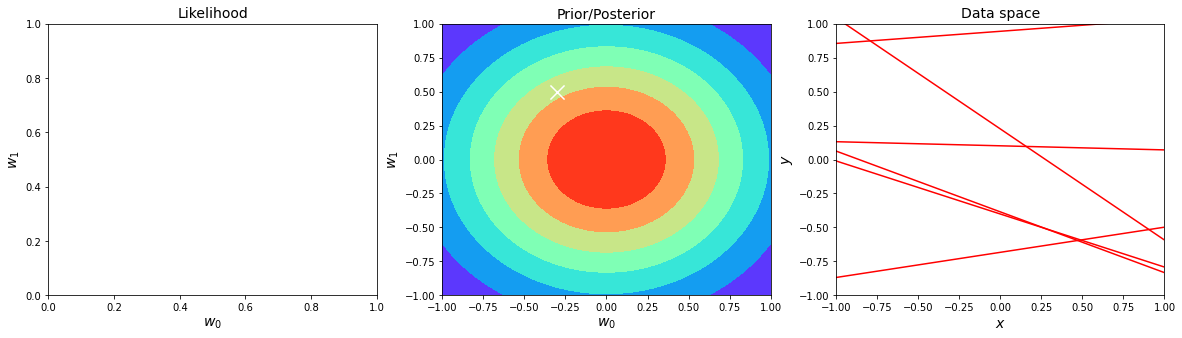

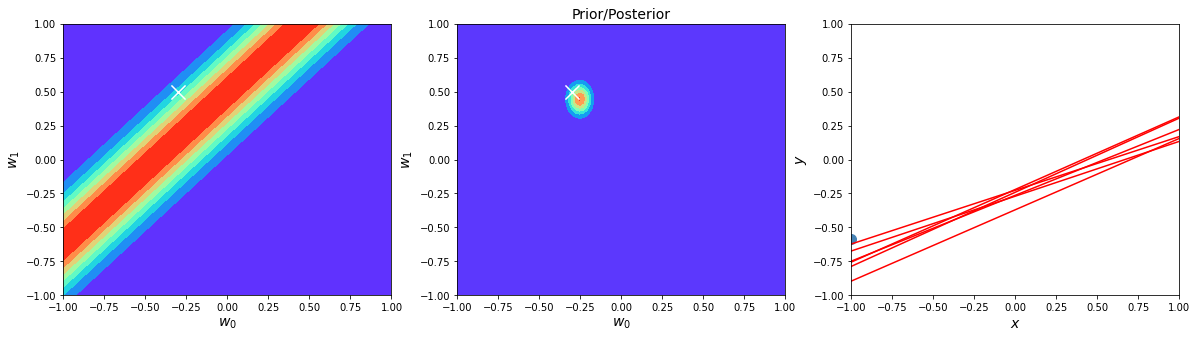

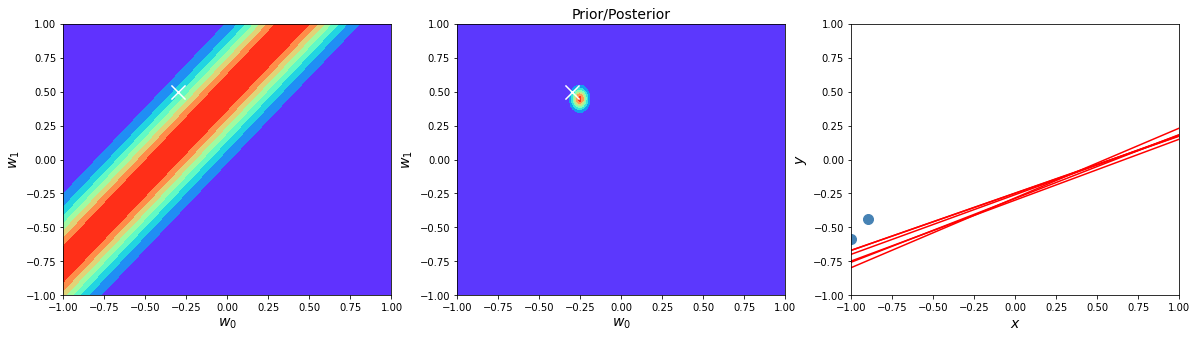

/home/vagmcs/Work/dev/projects/PRML/prml/distribution/multivariate_gaussian.py:98: RuntimeWarning: overflow encountered in exp
  * np.exp(-0.5 * (np.linalg.solve(self.cov, d).T.dot(d)))
/home/vagmcs/Work/dev/projects/PRML/prml/distribution/multivariate_gaussian.py:96: RuntimeWarning: overflow encountered in multiply
  1


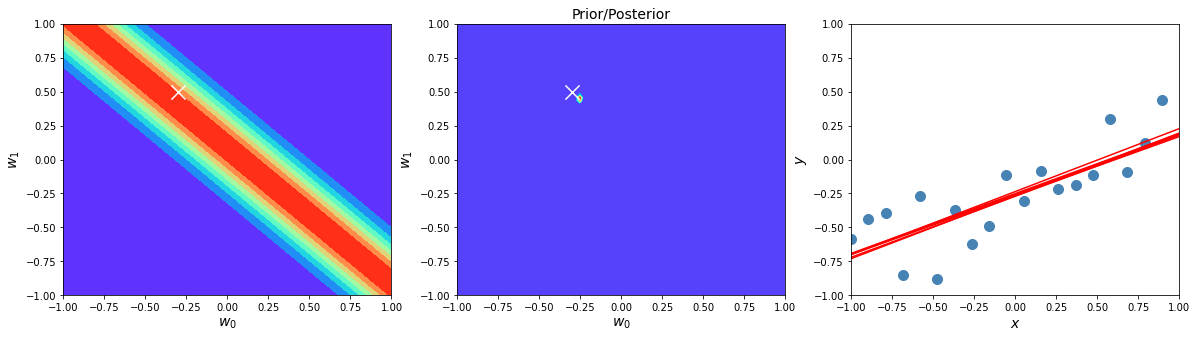

In [26]:
alpha = 2.
beta = 25.
N = 20

x_train, y_train = generate_toy_data(lambda x: 0.5 * x - 0.3, N, 0.2, (-1, 1))
x_train_linear = PolynomialFeature(degree=1).transform(x_train)

w0, w1 = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
w = np.array([np.ravel(w0), np.ravel(w1)])

prior_posterior = MultivariateGaussian(mu=np.zeros((2, 1)), cov=(1 / alpha) * np.eye(2))

for i, x in enumerate(x_train_linear):
    
    if i > 0:
        prev_precision = np.linalg.inv(prior_posterior.cov)
        cur_precision = prev_precision + beta * x_train_linear.T @ x_train_linear
        cur_cov = np.linalg.inv(cur_precision)
        cur_mean = cur_cov @ ((prev_precision @ prior_posterior.mu).T + beta * x_train_linear.T @ y_train).reshape(-1, 1)

        prior_posterior = MultivariateGaussian(mu=cur_mean, cov=cur_cov)
        
    if i < 3 or i == N - 1:
    
        plt.figure(figsize=(20, 5))

        # likelihood
        plt.subplot(1, 3, 1)
        if i == 0:
            plt.title('Likelihood', fontsize=14)
        else:
            likelihood = Gaussian(var=1 / beta).pdf(y_train[i])
            z = likelihood.pdf(mu=w.T @ x).reshape(w0.shape)
            plt.contourf(w0, w1, z, cmap='rainbow')
            plt.scatter(-0.3, 0.5, s=200, marker="x", color='white')

        plt.xlabel('$w_0$', fontsize=14)
        plt.ylabel('$w_1$', fontsize=14)

        # prior/posterior
        plt.subplot(1, 3, 2)
        plt.title('Prior/Posterior', fontsize=14)    
        z = np.diag(prior_posterior.pdf(w)).reshape(w0.shape)
        plt.contourf(w0, w1, z, cmap='rainbow')
        plt.scatter(-0.3, 0.5, s=200, marker="x", color='white')

        plt.xlabel('$w_0$', fontsize=14)
        plt.ylabel('$w_1$', fontsize=14)

        # data space
        plt.subplot(1, 3, 3)
        if i == 0:
            plt.title('Data space', fontsize=14)
        else:
            plt.scatter(x_train[:i], y_train[:i], s=100, color='steelblue')

        w_sample = prior_posterior.draw(6)
        y_sample = x_train_linear @ w_sample.T
        plt.plot(x_train, y_sample, color='red')
            
        plt.xlim(-1, 1); plt.ylim(-1, 1)
        plt.xlabel('$x$', fontsize=14)
        plt.ylabel('$y$', fontsize=14)

        plt.show()

### 3.3.2 Predictive distribution

In practice however, our goal is make predictions of $t$ for unseen values of $\mathbf{x}_{\text{unseen}}$, and thus, we are not actually interested in the value of $\mathbf{w}$ itself. To that end, we evaluate the *predictive distribution* given by

$$
p(t|\mathbf{x}_{\text{unseen}}, \mathsf{t},\mathbf{X},\alpha,\beta) = 
\int p(t|\mathbf{x}_{\text{unseen}},\mathbf{w},\beta)p(\mathbf{w}|\mathsf{t},\mathbf{X},\alpha,\beta)\text{d}\mathbf{w}
$$

Note that the predictive distribution involves the convolution of the conditional Gaussian distribution of the target variable and the posterior weight Gaussian distribution.

$$
\begin{align*}
p(t|\mathbf{x},\mathbf{w},\beta) &= 
\mathcal{N}(t|y(\mathbf{x},\mathbf{w}),\beta^{-1}) =
\mathcal{N}(t|\boldsymbol\phi(\mathbf{x})^\text{T}\mathbf{w},\beta^{-1}) \\
p(\mathbf{w}|\mathsf{t},\mathbf{X},\alpha,\beta) &= 
\mathcal{N}(\mathbf{w}|\mathbf{m}_N,\mathbf{S}_N)
\end{align*}
$$

Taking advantage of **(2.113)**, **(2.114)** and **(2.115)**, we can obtain

$$
p(t|\mathbf{x}_{\text{unseen}},\mathsf{t},\mathbf{X},\alpha,\beta) = 
\mathcal{N}(t|\mathbf{m}_N^\text{T}\boldsymbol\phi(\mathbf{x}_{\text{unseen}}),\sigma_N^2(\mathbf{x}_{\text{unseen}}))
$$

where the variance $\sigma_N^2(\mathbf{x})$ of the predictive distribution is given by

$$
\sigma_N^2(\mathbf{x}) = \frac{1}{\beta} + \boldsymbol\phi(\mathbf{x})^\text{T}\mathbf{S}_N\boldsymbol\phi(\mathbf{x})
$$

The first term represents the noise on the data whereas the second term reflects the uncertainty associated with the parameters $\mathbf{w}$.

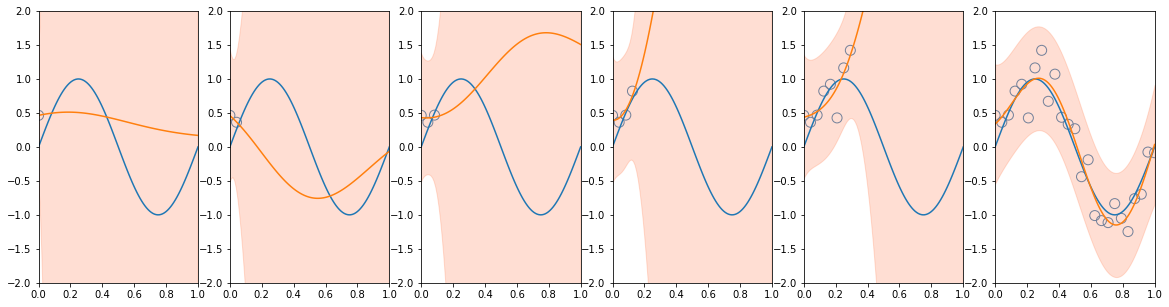

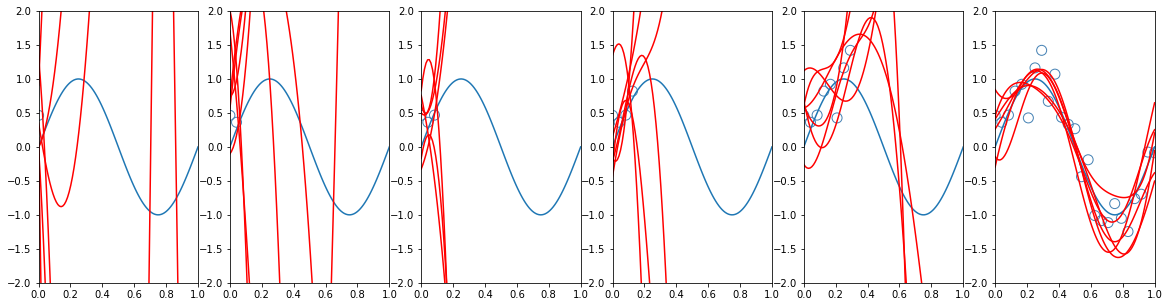

In [13]:
N = 25

def sinusoidal(x):
    return np.sin(2 * np.pi * x)

x_train, y_train = generate_toy_data(sinusoidal, N, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = sinusoidal(x_test)

feature = GaussianFeature(np.linspace(0, 1, 9), 0.1)
X_train = feature.transform(x_train)
X_test = feature.transform(x_test)

fig_idx = 1
plt.figure(figsize=(20, 5))
for i, x in enumerate(X_train):
    if i < 4 or i == 7 or i == N - 1:
        model = BayesianRegression(alpha=1e-3, beta=2.)
        model.fit(X_train[:i+1], y_train[:i+1])
        y, y_std = model.predict(X_test, return_std=True)

        plt.subplot(1, 6, fig_idx); fig_idx += 1
        plt.scatter(x_train[:i+1], y_train[:i+1], s=100, facecolor="none", edgecolor="steelblue")
        plt.plot(x_test, y_test)
        plt.plot(x_test, y)
        plt.fill_between(x_test, y - y_std, y + y_std, color="coral", alpha=0.25)
        plt.xlim(0, 1); plt.ylim(-2, 2)

plt.show()


fig_idx = 1
plt.figure(figsize=(20, 5))
for i, x in enumerate(X_train):
    if i < 4 or i == 7 or i == N - 1:  
        model = BayesianRegression(alpha=1e-3, beta=2.)
        model.fit(X_train[:i+1], y_train[:i+1])
        w_samples = model.draw(6)
        
        plt.subplot(1, 6, fig_idx); fig_idx += 1
        plt.scatter(x_train[:i+1], y_train[:i+1], s=100, facecolor="none", edgecolor="steelblue")
        plt.plot(x_test, y_test)
        plt.plot(x_test, X_test @ w_samples.T, color='red')
        plt.xlim(0, 1); plt.ylim(-2, 2)

plt.show()

### 3.3.3 Equivalent kernel

The posterior mean solution for the linear basis function model has an interesting interpretation. If we substitute the posterior mean solution $\mathbf{m}_N$, given by **(3.53)**, into the expression **(3.3)**, we note that the predictive mean can be expressed in the form

$$
y(\mathbf{x},\mathbf{m}_N) = \mathbf{m}_N^\text{T}\boldsymbol\phi(\mathbf{x}) = 
\beta\boldsymbol\phi(\mathbf{x})^\text{T}\mathbf{S}_N\boldsymbol\Phi^\text{T}\mathsf{t} = 
\sum_{n=1}^N \beta\boldsymbol\phi(\mathbf{x})^\text{T}\mathbf{S}_N\boldsymbol\phi(\mathbf{x}_n)t_n
$$

Thus the mean of the predictive distribution at point $\mathbf{x}$ is given by a linear combination of the training data set target variables $t_n$. 

$$
y(\mathbf{x},\mathbf{m}_N) = \sum_{n=1}^N k(\mathbf{x},\mathbf{x}_n)t_n
$$

where the function

$$
k(\mathbf{x},\mathbf{x}') = 
\beta\boldsymbol\phi(\mathbf{x})^\text{T}\mathbf{S}_N\boldsymbol\phi(\mathbf{x}')
$$

is known as the *smoother matrix* or the *equivalent kernel*. Regression functions that make predictions by taking linear combinations of the training set target values are known as *linear smoothers*.

Further insight into the equivalent kernel can be obtained by considering the covariance between $y(\mathbf{x})$ and $y(\mathbf{x}')$,

$$
\text{cov}[y(\mathbf{x}),y(\mathbf{x}')] = 
\text{cov}[\boldsymbol\phi(\mathbf{x})^\text{T}\mathbf{w},\mathbf{w}^\text{T}\boldsymbol\phi(\mathbf{x})] =
\boldsymbol\phi(\mathbf{x})^\text{T}\mathbf{S}_N\boldsymbol\phi(\mathbf{x}') =
\beta^{-1}k(\mathbf{x},\mathbf{x}')
$$

Therefore, the predictive mean at nearby points is highly correlated, whereas for more distant pairs of points the correlation is smaller.

**!!!** This formulation of linear regression suggests an alternative approach to regression as follows. Instead of introducing a set of basis functions $\phi_j$ to derive an equivalent kernel, we may instead define the kernel $k(\mathbf{x},\mathbf{x}')$ directly and use the it to make predictions, given an observed training set.

## 3.5 The Evidence Approximation

In a fully Bayesian treatment of the linear basis function model one can introduce prior distributions over the hyperparameters $\alpha$ and $\beta$ and make predictions by marginalizing over these hyperparameters in addition to the model parameters $\mathbf{w}$. However, the complete marginalization over these variables is analytically intractable. A useful approximation is to set the hyperparameters to specific values by maximizing the marginal likelhood obtained by intergrating over the model parameters $\mathbf{w}$. This framework is known in statistics as *empirical bayes* or *type 2 maximum likelihood* or *generalized maximum likelihood*. In machine learning is also called *evidence approximation*.

The predictive distribution is obtained by marginalizing over $\mathbf{w}$, $\alpha$ and $\beta$ so that

$$
p(t|\tilde{\mathbf{x}},\mathsf{t},\mathbf{X}) = 
\int\int\int 
p(t|\mathbf{w},\tilde{\mathbf{x}},\beta)
p(\mathbf{w}|\mathsf{t},\mathbf{X},\alpha,\beta)
p(\alpha,\beta|\mathsf{t},\mathbf{X})
\text{d}\mathbf{w}\text{d}\alpha\text{d}\beta
$$

Assuming that the posterior distribution $p(\alpha,\beta|\mathsf{t},\mathbf{X})$ is sharply peaked around some values $\hat{\alpha}$ and $\hat{\beta}$, then the predictive distribution is obtained by fixing $\alpha$ and $\beta$ to these values and marginalizing over $\mathbf{w}$

$$
p(t|\tilde{\mathbf{x}},\mathsf{t},\mathbf{X}) \approx 
p(t|\tilde{\mathbf{x}},\mathsf{t},\mathbf{X},\hat{\alpha},\hat{\beta}) = 
\int 
p(t|\tilde{\mathbf{x}},\mathbf{w},\hat{\beta})
p(\mathbf{w}|\mathsf{t},\mathbf{X},\hat{\alpha},\hat{\beta})
\text{d}\mathbf{w}
$$

in which case we arrive at the simpler predictive distribution defined by (3.57).

The posterior distribution for $\alpha$ and $\beta$ is given by

$$
p(\alpha,\beta|\mathsf{t},\mathbf{X}) \propto 
p(\mathsf{t}|\mathbf{X},\alpha,\beta)p(\alpha,\beta)
$$

Further assuming that the prior is relatively flat, that is, our prior belief is that different values of $\alpha$ and $\beta$ are somewhat equiprobable. Then, the sharply peaked area assumed for the posterior ($\hat{\alpha}$ and $\hat{\beta}$) should be found by maximizing the marginal likelihood function $p(\mathsf{t}|\mathbf{X},\alpha,\beta)$.

### 3.5.1 Evaluation of the evidence function

The marginal likelihood function $p(\mathsf{t}|\mathbf{X},\alpha,\beta)$ is obtained by integrating over the model parameters $\mathbf{w}$, so that,

$$
p(\mathsf{t}|\mathbf{X},\alpha,\beta) = 
\int p(\mathsf{t}|\mathbf{X},\mathbf{w},\beta)p(\mathbf{w}|\alpha)\text{d}\mathbf{w}
$$

From **(3.10)** we have that

$$
\begin{align*}
p(\mathsf{t}|\mathbf{X},\mathbf{w},\beta) &= 
\prod_{n=1}^N \mathcal{N}(t_n|\mathbf{w}^\text{T}\boldsymbol\phi(\mathbf{x}_n),\beta^{-1}) \\
&= \prod_{n=1}^N \frac{1}{(2\pi\beta^{-1})^{1/2}}
\exp\big\{ -\frac{1}{2\beta^{-1}}\big(t_n - \mathbf{w}^\text{T}\boldsymbol\phi(\mathbf{x}_n)\big)^2 \big\} \\
&= N\bigg(\frac{\beta}{2\pi}\bigg)^{1/2}
\exp\big\{ 
    \sum_{n=1}^N -\frac{1}{2\beta^{-1}}\big(t_n - \mathbf{w}^\text{T}\boldsymbol\phi(\mathbf{x}_n)\big)^2 
\big\} \\
&= \bigg(\frac{\beta}{2\pi}\bigg)^{N/2} 
\exp\big\{ -\frac{\beta}{2} \|\mathsf{t} - \boldsymbol\Phi\mathbf{w} \|^2 \big\}
\end{align*}
$$

From **(3.52)** we have that

$$
p(\mathbf{w}|\alpha) = \mathcal{N}(\mathbf{w}|\mathbf{0},\alpha^{-1}\mathbf{I}) = 
\frac{\alpha^{M/2}}{(2\pi)^{M/2}}\exp\big\{-\frac{\alpha}{2}\|\mathbf{w}\|^2\big\}
$$

Substituting both these quantities back into the integral of the marginal likelihood, we have

$$
p(\mathsf{t}|\mathbf{X},\alpha,\beta) = 
\bigg(\frac{\beta}{2\pi}\bigg)^{N/2} \bigg(\frac{\alpha}{2\pi}\bigg)^{M/2} \int 
\exp\big\{ 
    -\frac{\beta}{2} \|\mathsf{t} - \boldsymbol\Phi\mathbf{w} \|^2 -\frac{\alpha}{2}\|\mathbf{w}\|^2
\big\} \text{d}\mathbf{w}
$$

Using **(3.25)** and **(3.26)** we obtain

$$
p(\mathsf{t}|\mathbf{X},\alpha,\beta) = 
\bigg(\frac{\beta}{2\pi}\bigg)^{N/2} \bigg(\frac{\alpha}{2\pi}\bigg)^{M/2} \int 
\exp\big\{ -E(\mathbf{w}) \big\} \text{d}\mathbf{w}
$$

where

$$
E(\mathbf{w}) = \beta E_D(\mathbf{w}) + \alpha E_W(\mathbf{w})
$$

Completing the square over $\mathbf{w}$, we obtain

$$
\begin{align*}
E(\mathbf{w}) &= 
\frac{\beta}{2} \|\mathsf{t} - \boldsymbol\Phi\mathbf{w} \|^2 + \frac{\alpha}{2}\|\mathbf{w}\|^2 \\
&= \frac{\beta}{2} \big(
    \mathsf{t}^\text{T}\mathsf{t} - 
    2\mathsf{t}^\text{T}\boldsymbol\Phi\mathbf{w} + 
    \mathbf{w}^\text{T}\boldsymbol\Phi^\text{T}\boldsymbol\Phi\mathbf{w}
\big) + 
\frac{\alpha}{2}\mathbf{w}^\text{T}\mathbf{w} \\
&= \frac{1}{2} \big(
\mathbf{w}^\text{T}(\alpha\mathbf{I} + \beta\boldsymbol\Phi^\text{T}\boldsymbol\Phi)\mathbf{w} -
2\beta\mathsf{t}^\text{T}\boldsymbol\Phi\mathbf{w} +
\beta\mathsf{t}^\text{T}\mathsf{t}
\big)
\end{align*}
$$

where

$$
\begin{align*}
\mathbf{A} &= \mathbf{S}_N^{-1} = \alpha\mathbf{I} + \beta\boldsymbol\Phi^\text{T}\boldsymbol\Phi \\
\mathbf{m}_N^\text{T}\mathbf{S}_N^{-1} &= \beta\mathsf{t}^\text{T}\boldsymbol\Phi \Leftrightarrow \\
\mathbf{m}_N^\text{T} &= \beta\mathbf{S}_N\mathsf{t}^\text{T}\boldsymbol\Phi \Leftrightarrow \\
\mathbf{m}_N &= \beta\mathbf{S}_N\boldsymbol\Phi^\text{T}\mathsf{t} = 
\beta\mathbf{A}^{-1}\boldsymbol\Phi^\text{T}\mathsf{t}
\end{align*}
$$

By exploiting the fact $\mathbf{A}^{-1}\mathbf{A}=\mathbf{I}$ and adding $\mathbf{0}=\mathbf{m}_N^\text{T}\mathbf{A}\mathbf{m}_N - \mathbf{m}_N^\text{T}\mathbf{A}\mathbf{m}_N$, we can further derive that

$$
\begin{align*}
E(\mathbf{w}) &= \frac{1}{2} \big(
\mathbf{w}^\text{T}(\alpha\mathbf{I} + \beta\boldsymbol\Phi^\text{T}\boldsymbol\Phi)\mathbf{w} -
2\beta\mathsf{t}^\text{T}\boldsymbol\Phi\mathbf{w} +
\beta\mathsf{t}^\text{T}\mathsf{t}
\big) \\
&= \frac{1}{2} \big(
\mathbf{w}^\text{T}\mathbf{A}\mathbf{w} -
2\beta\mathsf{t}^\text{T}\boldsymbol\Phi\mathbf{A}^{-1}\mathbf{A}\mathbf{w} +
\beta\mathsf{t}^\text{T}\mathsf{t}
\big) \\
&= \frac{1}{2} \big(
\mathbf{w}^\text{T}\mathbf{A}\mathbf{w} -
2\mathbf{m}_N\mathbf{A}\mathbf{w} +
\beta\mathsf{t}^\text{T}\mathsf{t} +
\mathbf{m}_N^\text{T}\mathbf{A}\mathbf{m}_N - \mathbf{m}_N^\text{T}\mathbf{A}\mathbf{m}_N
\big) \\
&= \frac{1}{2} (\beta\mathsf{t}^\text{T}\mathsf{t} - \mathbf{m}_N^\text{T}\mathbf{A}\mathbf{m}_N)
+ \frac{1}{2} (\mathbf{w} - \mathbf{m}_N)^\text{T}\mathbf{A}(\mathbf{w} - \mathbf{m}_N)
\end{align*}
$$

At this point note that the first term is independent of the model parameters $\mathbf{w}$ and the second term is an exponent of a Gaussian distribution over the model parameters. Therefore the integral over $\mathbf{w}$ of $p(\mathsf{t}|\mathbf{X},\alpha,\beta)$ is given by

$$
p(\mathsf{t}|\mathbf{X},\alpha,\beta) = 
\bigg(\frac{\beta}{2\pi}\bigg)^{N/2} \bigg(\frac{\alpha}{2\pi}\bigg)^{M/2} 
\exp \big\{ 
    -\frac{1}{2} (\beta\mathsf{t}^\text{T}\mathsf{t} - \mathbf{m}_N^\text{T}\mathbf{A}\mathbf{m}_N) 
\big\}
\int 
\exp\big\{ 
    -\frac{1}{2} (\mathbf{w} - \mathbf{m}_N)^\text{T}\mathbf{A}(\mathbf{w} - \mathbf{m}_N) 
\big\} \text{d}\mathbf{w}
$$

However, based on the standard form of a multivariate normal distribution, we know that

$$
\begin{align*}
& \int \frac{1}{(2\pi)^{M/2}}\frac{1}{|\mathbf{A}|^{1/2}}
\exp\big\{ 
    -\frac{1}{2} (\mathbf{w} - \mathbf{m}_N)^\text{T}\mathbf{A}(\mathbf{w} - \mathbf{m}_N) 
\big\} \text{d}\mathbf{w} = 1 \Leftrightarrow \\
& \int \exp\big\{ 
    -\frac{1}{2} (\mathbf{w} - \mathbf{m}_N)^\text{T}\mathbf{A}(\mathbf{w} - \mathbf{m}_N) 
\big\} \text{d}\mathbf{w} = 
(2\pi)^{M/2}|\mathbf{A}|^{-1/2}
\end{align*}
$$

Thus,

$$
p(\mathsf{t}|\mathbf{X},\alpha,\beta) = 
\bigg(\frac{\beta}{2\pi}\bigg)^{N/2} \bigg(\frac{\alpha}{2\pi}\bigg)^{M/2} 
\exp \big\{ 
    -\frac{1}{2} (\beta\mathsf{t}^\text{T}\mathsf{t} - \mathbf{m}_N^\text{T}\mathbf{A}\mathbf{m}_N) 
\big\}
(2\pi)^{M/2}|\mathbf{A}|^{-1/2}
$$

Thus, the log of the marginal likelihood is given by

$$
\begin{align*}
    \log p(\mathsf{t}|\mathbf{X},\alpha,\beta) 
    &=
    \frac{N}{2}\log\bigg(\frac{\beta}{2\pi}\bigg) +
    \frac{M}{2}\log\bigg(\frac{\alpha}{2\pi}\bigg) -
    \frac{1}{2} (\beta\mathsf{t}^\text{T}\mathsf{t} - \mathbf{m}_N^\text{T}\mathbf{A}\mathbf{m}_N) +
    \frac{M}{2}\log(2\pi) -
    \frac{1}{2}|\mathbf{A}| \\
    &=
    \frac{M}{2}\log\alpha +
    \frac{N}{2}\log\beta -
    \frac{1}{2} \big(\beta\mathsf{t}^\text{T}\mathsf{t} - \mathbf{m}_N^\text{T}\mathbf{A}\mathbf{m}_N\big) -
    \frac{1}{2}|\mathbf{A}| -
    \frac{N}{2}\log(2\pi)
\end{align*}
$$

As a final step we are about to show that $\frac{1}{2} \big(\beta\mathsf{t}^\text{T}\mathsf{t} - \mathbf{m}_N^\text{T}\mathbf{A}\mathbf{m}_N\big) = E(\mathbf{w})$

$$
\begin{align*}
\frac{1}{2} \big(
    \beta\mathsf{t}^\text{T}\mathsf{t} - 
    \mathbf{m}_N^\text{T}\mathbf{A}\mathbf{m}_N
\big) 
&=
\frac{1}{2} \big(
    \beta\mathsf{t}^\text{T}\mathsf{t} - 
    2\mathbf{m}_N^\text{T}\mathbf{A}\mathbf{m}_N +
    \mathbf{m}_N^\text{T}\mathbf{A}\mathbf{m}_N
\big) \\
&\overset{\textbf{(3.81)}}=
\frac{1}{2} \big(
    \beta\mathsf{t}^\text{T}\mathsf{t} - 
    2\mathbf{m}_N^\text{T}\mathbf{A}\mathbf{m}_N -
    \mathbf{m}_N^\text{T}(\alpha\mathbf{I} + \beta\mathbf{\Phi}^\text{T}\mathbf{\Phi})\mathbf{m}_N
\big) \\
&\overset{\textbf{(3.84)}}=
\frac{1}{2} \big(
    \beta\mathsf{t}^\text{T}\mathsf{t} - 
    2\beta\mathsf{t}^\text{T}\mathbf{\Phi}\mathbf{A}^{-1}\mathbf{A}\mathbf{m}_N -
    \mathbf{m}_N^\text{T}(\alpha\mathbf{I} + \beta\mathbf{\Phi}^\text{T}\mathbf{\Phi})\mathbf{m}_N
\big) \\
&=
\frac{1}{2} \big(
    \beta\mathsf{t}^\text{T}\mathsf{t} - 
    2\beta\mathsf{t}^\text{T}\mathbf{\Phi}\mathbf{m}_N -
    \mathbf{m}_N^\text{T}(\beta\mathbf{\Phi}^\text{T}\mathbf{\Phi})\mathbf{m}_N
\big) + \frac{\alpha}{2} \mathbf{m}_N^\text{T}\mathbf{m}_N \\
&=
\frac{1}{2} \|\mathsf{t} - \mathbf{\Phi}\mathbf{m}_N\|^2 + \frac{\alpha}{2} \mathbf{m}_N^\text{T}\mathbf{m}_N
= E(\mathbf{w})
\end{align*}
$$

### 3.5.2 Maximizing the evidence function

Lets consider the maximization of $p(\mathsf{t}|\mathbf{X},\alpha,\beta)$ over $\alpha$,

$$
\begin{align*}
    \frac{d}{d\alpha} p(\mathsf{t}|\mathbf{X},\alpha,\beta) 
    &=
    \frac{d}{d\alpha}\frac{M}{2}\log\alpha - 
    \frac{d}{d\alpha}E(\mathbf{w}) - 
    \frac{d}{d\alpha}\frac{1}{2}\log|\mathbf{A}| \\
    &=
    \frac{M}{2\alpha} -
    \frac{1}{2}\mathbf{m}_N^\text{T}\mathbf{m}_N -
    \frac{1}{2}\frac{d}{d\alpha}\ln|\mathbf{A}|
\end{align*}
$$

In order to find the derivative of $\ln|\mathbf{A}|$, we use the eigenvector equation of **(C.29)**

$$
\begin{align*}
\big(\beta\mathbf{\Phi}^\text{T}\mathbf{\Phi}\big)\mathbf{u}_i = \lambda_i\mathbf{u}_i 
&\overset{\textbf{(C.30)}}\Leftrightarrow
|\beta\mathbf{\Phi}^\text{T}\mathbf{\Phi} - \lambda_i\mathbf{I}| = \mathbf{0} \\
&\overset{\textbf{(3.81)}}\Leftrightarrow
|\mathbf{A} - \alpha\mathbf{I} - \lambda_i\mathbf{I}| = \mathbf{0} \\
&\,\,\Leftrightarrow \,\,
|\mathbf{A} - (\lambda_i + \alpha)\mathbf{I}| = \mathbf{0}
\end{align*}
$$

Therefore, we can derive that $\mathbf{A}$ has eigenvalues $\lambda_i + \alpha$. In conclusion, the derivative of the term involving $\ln|\mathbf{A}|$ is given by

$$
\frac{d}{d\alpha}\ln|\mathbf{A}| \overset{\textbf{(C.47)}}= 
\frac{d}{d\alpha}\ln\prod_{i=1}^{M}(\lambda_i + \alpha) =
\frac{d}{d\alpha}\sum_{i=1}^{M}\ln(\lambda_i + \alpha) =
\sum_{i=1}^{M}\frac{1}{\lambda_i + \alpha}
$$

Thus, the resulting solution for $\alpha$, as presented in eq. **(3.92)**, is given by

$$
\begin{align*}
&
0 = 
\frac{M}{2\alpha} -
\frac{1}{2}\mathbf{m}_N^\text{T}\mathbf{m}_N -
\frac{1}{2}\sum_{i=1}^{M}\frac{1}{\lambda_i + \alpha}
\Leftrightarrow \\
& 
\frac{1}{2}\mathbf{m}_N^\text{T}\mathbf{m}_N = 
\frac{M}{2\alpha} - \frac{1}{2}\sum_{i=1}^{M}\frac{1}{\lambda_i + \alpha}
\overset{\times\,2\alpha}\Leftrightarrow \\
&
\alpha\mathbf{m}_N^\text{T}\mathbf{m}_N = 
M - \alpha\sum_{i=1}^{M}\frac{1}{\lambda_i + \alpha}
\Leftrightarrow \\
&
\alpha\mathbf{m}_N^\text{T}\mathbf{m}_N = 
M\frac{\lambda_i + \alpha}{\lambda_i + \alpha} - \sum_{i=1}^{M}\frac{\alpha}{\lambda_i + \alpha}
\Leftrightarrow \\
&
\alpha\mathbf{m}_N^\text{T}\mathbf{m}_N = \sum_{i=1}^{M}\frac{\lambda_i}{\lambda_i + \alpha} = \gamma
\Leftrightarrow \\
&
\alpha = \frac{\gamma}{\mathbf{m}_N^\text{T}\mathbf{m}_N}
\end{align*}
$$

Note that this is an implicit solution for $\alpha$, since both $\gamma$ and $\mathbf{m}_N$ depend on $\alpha$. Thus, we have to use an iterative procedure to estimate $\alpha$ by making an starting choice for the value of $\alpha$, computing $\mathbf{m}_N$, evaluating $\gamma$ **(3.91)** and re-estimating $\alpha$ **(3.92)**, until convergence. It should be *emphasized* that the value of $\alpha$ can be determined purely by looking at the training data. No independent dataset is required in order to optimize model complexity.

The maximization of $p(\mathsf{t}|\mathbf{X},\alpha,\beta)$ over $\beta$ is given by

$$
\begin{align*}
    \frac{d}{d\beta} p(\mathsf{t}|\mathbf{X},\alpha,\beta) 
    &=
    \frac{d}{d\beta}\frac{N}{2}\log\beta - 
    \frac{d}{d\beta}E(\mathbf{w}) - 
    \frac{d}{d\beta}\frac{1}{2}\log|\mathbf{A}| \\
    &=
    \frac{N}{2\beta} -
    \frac{d}{d\beta}E(\mathbf{w}) -
    \frac{1}{2}\frac{d}{d\beta}\ln|\mathbf{A}|
\end{align*}
$$

Lets take a closer look to the second term,

$$
\begin{align*}
    \frac{d}{d\beta}E(\mathbf{w}) &= 
    \frac{d}{d\beta}\frac{\beta}{2}\|\mathsf{t} - \mathbf{\Phi}\mathbf{m}_N\|^2 +
    \frac{d}{d\beta}\frac{\alpha}{2}\mathbf{m}_N^\text{T}\mathbf{m}_N \\
    &\overset{\textbf{product rule}}=
    \frac{1}{2}\|\mathsf{t} - \mathbf{\Phi}\mathbf{m}_N\|^2 +
    \frac{\beta}{2}\frac{d}{d\beta}\|\mathsf{t} - \mathbf{\Phi}\mathbf{m}_N\|^2 +
    \frac{d}{d\beta}\frac{\alpha}{2}\mathbf{m}_N^\text{T}\mathbf{m}_N \\
    &\overset{\times\; d\mathbf{m}_N/d\mathbf{m}_N}= 
    \frac{1}{2}\|\mathsf{t} - \mathbf{\Phi}\mathbf{m}_N\|^2 +
    \bigg(
    \frac{\beta}{2}\frac{d}{d\mathbf{m}_N}\|\mathsf{t} - \mathbf{\Phi}\mathbf{m}_N\|^2 +
    \frac{d}{d\mathbf{m}_N}\frac{\alpha}{2}\mathbf{m}_N^\text{T}\mathbf{m}_N
    \bigg) \frac{d\mathbf{m}_N}{d\beta} \\
    &= 
    \frac{1}{2}\|\mathsf{t} - \mathbf{\Phi}\mathbf{m}_N\|^2 +
    \bigg(
    \frac{\beta}{2}\big(-2\mathbf{\Phi}^\text{T}\big(\mathsf{t} - \mathbf{\Phi}\mathbf{m}_N\big)\big) +
    \frac{\alpha}{2}2\mathbf{m}_N
    \bigg) \frac{d\mathbf{m}_N}{d\beta} \\
    &= 
    \frac{1}{2}\|\mathsf{t} - \mathbf{\Phi}\mathbf{m}_N\|^2 +
    \bigg(
    -\beta\mathbf{\Phi}^\text{T}\big(\mathsf{t} - \mathbf{\Phi}\mathbf{m}_N\big) +
    \alpha\mathbf{m}_N
    \bigg) \frac{d\mathbf{m}_N}{d\beta} \\
    &= 
    \frac{1}{2}\|\mathsf{t} - \mathbf{\Phi}\mathbf{m}_N\|^2 +
    \bigg(
    -\beta\mathbf{\Phi}^\text{T}\mathsf{t} - 
    \big(\alpha\mathbf{I} + \mathbf{\Phi}^\text{T}\mathbf{\Phi}\big)\mathbf{m}_N
    \bigg) \frac{d\mathbf{m}_N}{d\beta} \\
    &\overset{\textbf{(3.81)}}= 
    \frac{1}{2}\|\mathsf{t} - \mathbf{\Phi}\mathbf{m}_N\|^2 +
    \big(
    -\beta\mathbf{\Phi}^\text{T}\mathsf{t} - \mathbf{A}\mathbf{m}_N
    \big) \frac{d\mathbf{m}_N}{d\beta} \\
    &\overset{\textbf{(3.84)}}= 
    \frac{1}{2}\|\mathsf{t} - \mathbf{\Phi}\mathbf{m}_N\|^2
    =
    \frac{1}{2}\sum_{n=1}^N\big\{t_n - \mathbf{m}_N^\text{T}\mathbf{\phi}(\mathbf{x}_n)\big\}^2
\end{align*}
$$

The last term involving the derivative of $\ln|\mathbf{A}|$ becomes

$$
\frac{d}{d\beta}\ln|\mathbf{A}| = 
\frac{d}{d\beta}\sum_{i=1}^{M}\ln(\lambda_i + \alpha) =
\sum_{i=1}^{M}\frac{1}{\lambda_i + \alpha}\frac{d}{d\beta}\lambda_i =
\frac{1}{\beta}\sum_{i=1}^{M}\frac{\lambda_i}{\lambda_i + \alpha} =
\frac{\gamma}{\beta}
$$

Finally, if we combine all these expressions together, we obtain

$$
\begin{align*}
&
0 = 
\frac{Ν}{2\beta} -
\frac{1}{2}\sum_{n=1}^N \big\{t_n - \mathbf{m}_N^\text{T}\boldsymbol\phi(\mathbf{x}_n)\big\}^2 -
\frac{\gamma}{2\beta}
\Leftrightarrow \\
&
\frac{1}{\beta} =
\frac{1}{N-\gamma}\sum_{n=1}^N \big\{t_n - \mathbf{m}_N^\text{T}\boldsymbol\phi(\mathbf{x}_n)\big\}^2
\end{align*}
$$

As expected, the solution for $\beta$ is also implicit. If both $\alpha$ and $\beta$ are to be determined, then their values can be re-estimated together after each update of $\gamma$.

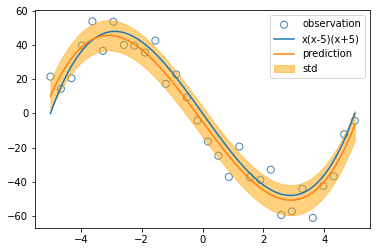

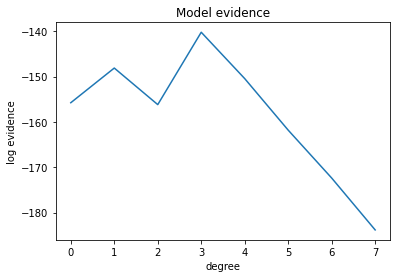

In [14]:
def cubic(x):
    return x * (x - 5) * (x + 5)

x_train, y_train = generate_toy_data(cubic, 30, 10, [-5, 5])
x_test = np.linspace(-5, 5, 100)
evidences = []
models = []
for i in range(8):
    feature = PolynomialFeature(degree=i)
    X_train = feature.transform(x_train)
    model = EvidenceApproximation(alpha=100., beta=100.)
    model.fit(X_train, y_train, n_iter=100)
    evidences.append(model.log_evidence(X_train, y_train))
    models.append(model)

degree = np.nanargmax(evidences)
regression = models[degree]

X_test = PolynomialFeature(degree=int(degree)).transform(x_test)
y, y_std = regression.predict(X_test, return_std=True)

plt.scatter(x_train, y_train, s=50, facecolor="none", edgecolor="steelblue", label="observation")
plt.plot(x_test, cubic(x_test), label="x(x-5)(x+5)")
plt.plot(x_test, y, label="prediction")
plt.fill_between(x_test, y - y_std, y + y_std, alpha=0.5, label="std", color="orange")
plt.legend()
plt.show()

plt.plot(evidences)
plt.title("Model evidence")
plt.xlabel("degree")
plt.ylabel("log evidence")
plt.show()